Adapted from: https://github.com/facebookresearch/flow_matching/blob/main/examples/standalone_flow_matching.ipynb

In [1]:
import torch 
from torch import nn, Tensor

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [2]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1 + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
        self.set_guidance_scale()

    def set_guidance_scale(self, s: float = 1.5):
        self.scale = s
    
    def forward(self, t: Tensor, x_t: Tensor, p: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t, p), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor, p: Tensor, CFG=False) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)

        if CFG:
            return x_t + (t_end - t_start) * ( (self.scale) * self(x_t=x_t, t=t_start, p=p) + (1-self.scale) * self(x_t=x_t, t=t_start, p=torch.zeros_like(t_start)) )
        else:
            return x_t + (t_end - t_start) * self(t=t_start, x_t=x_t, p=p)

# Let's train Flow model for prompt-guided generation

## First, we only train the model to work with non-null prompts. This model won't be able to generate unconditional (i.e. null-prompt) samples

In [3]:
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(10000):
    x_1, p = make_moons(256, noise=0.05)
    x_1 = Tensor(x_1)
    p   = 2*Tensor(p)[:,None] - 1 # map 0/1 to -1/1
    
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t, p=p), dx_t).backward()
    optimizer.step()

## Sampling with null-prompts

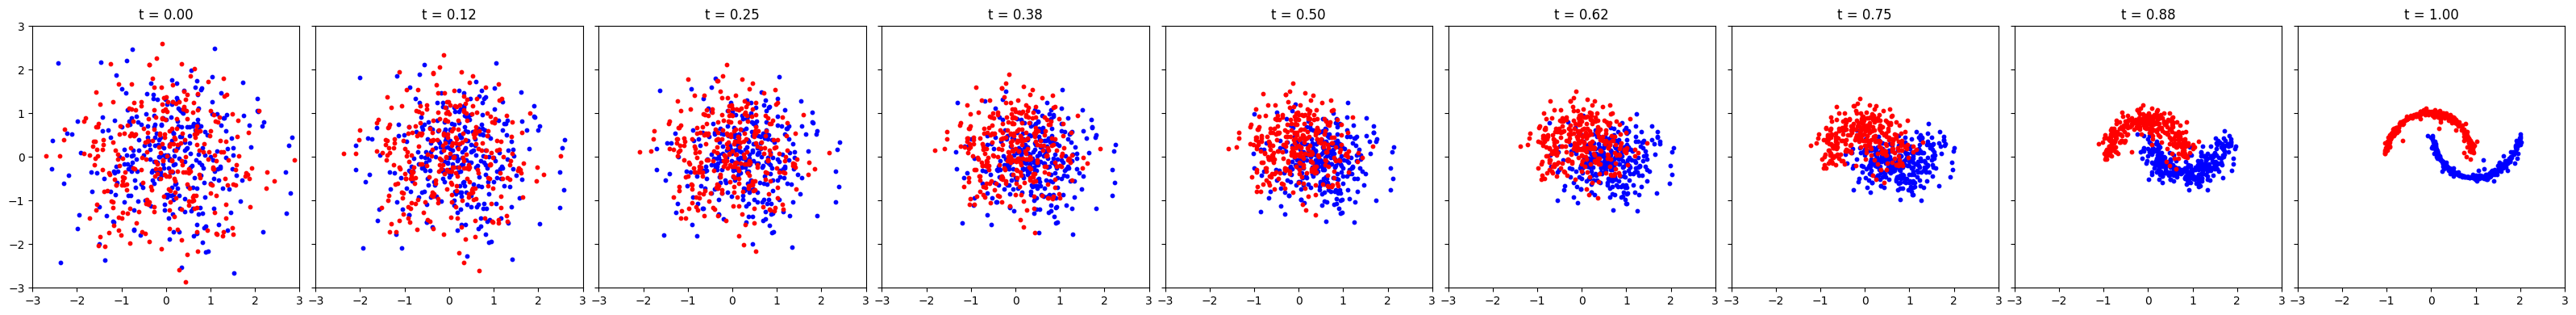

In [4]:
xa, xb = torch.randn(300, 2), torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(4*n_steps, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(xa.detach()[:, 0], xa.detach()[:, 1], s=10, c='b')
axes[0].scatter(xb.detach()[:, 0], xb.detach()[:, 1], s=10, c='r')
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    xa = flow.step(x_t=xa, t_start=time_steps[i], t_end=time_steps[i + 1], p=torch.ones((300,1)))
    xb = flow.step(x_t=xb, t_start=time_steps[i], t_end=time_steps[i + 1], p=-torch.ones((300,1)))
    axes[i + 1].scatter(xa.detach()[:, 0], xa.detach()[:, 1], s=10, c='b')
    axes[i + 1].scatter(xb.detach()[:, 0], xb.detach()[:, 1], s=10, c='r')
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()

## Sampling with null-prompts

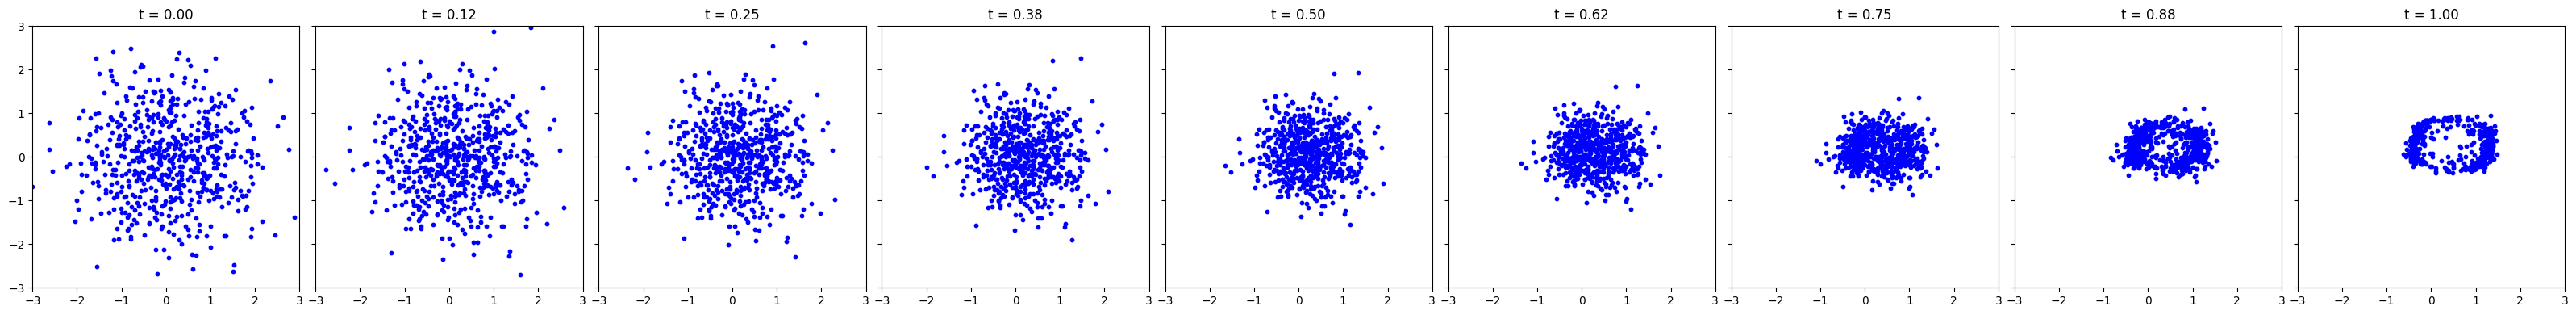

In [5]:
xa = torch.randn(600, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(4*n_steps, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(xa.detach()[:, 0], xa.detach()[:, 1], s=10, c='b')
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    xa = flow.step(x_t=xa, t_start=time_steps[i], t_end=time_steps[i + 1], p=torch.zeros((600,1)))
    axes[i + 1].scatter(xa.detach()[:, 0], xa.detach()[:, 1], s=10, c='b')
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()

## Let's train from scratch again to accept null-prompt as well

In [6]:
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(10000):
    x_1, p = make_moons(256, noise=0.05)
    x_1 = Tensor(x_1)
    p   = 2*Tensor(p)[:,None] - 1 # map 0/1 to -1/1
    p   = p * torch.randint(low=0, high=2, size=(256,1), dtype=torch.float32) # randomly flip some labels to null-labels = 0
    
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t, p=p), dx_t).backward()
    optimizer.step()

## Sampling with null-prompts

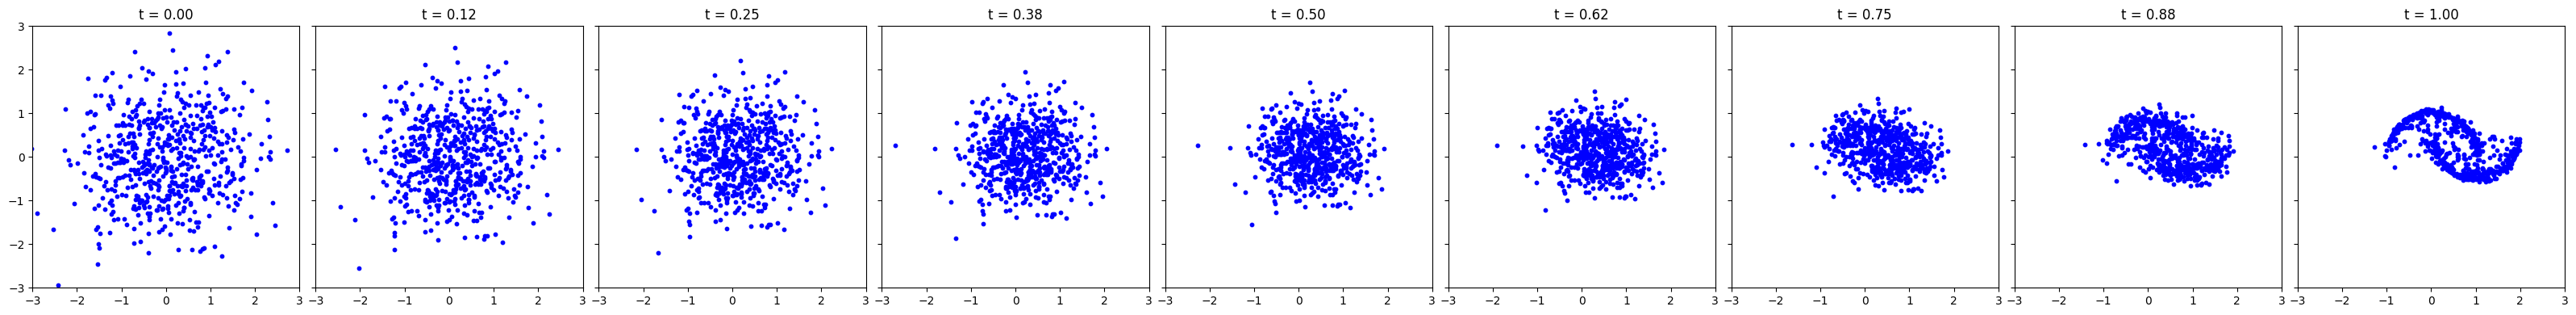

In [7]:
xa = torch.randn(600, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(4*n_steps, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(xa.detach()[:, 0], xa.detach()[:, 1], s=10, c='b')
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    xa = flow.step(x_t=xa, t_start=time_steps[i], t_end=time_steps[i + 1], p=torch.zeros((600,1)))
    axes[i + 1].scatter(xa.detach()[:, 0], xa.detach()[:, 1], s=10, c='b')
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()

## Sampling with non-null prompts

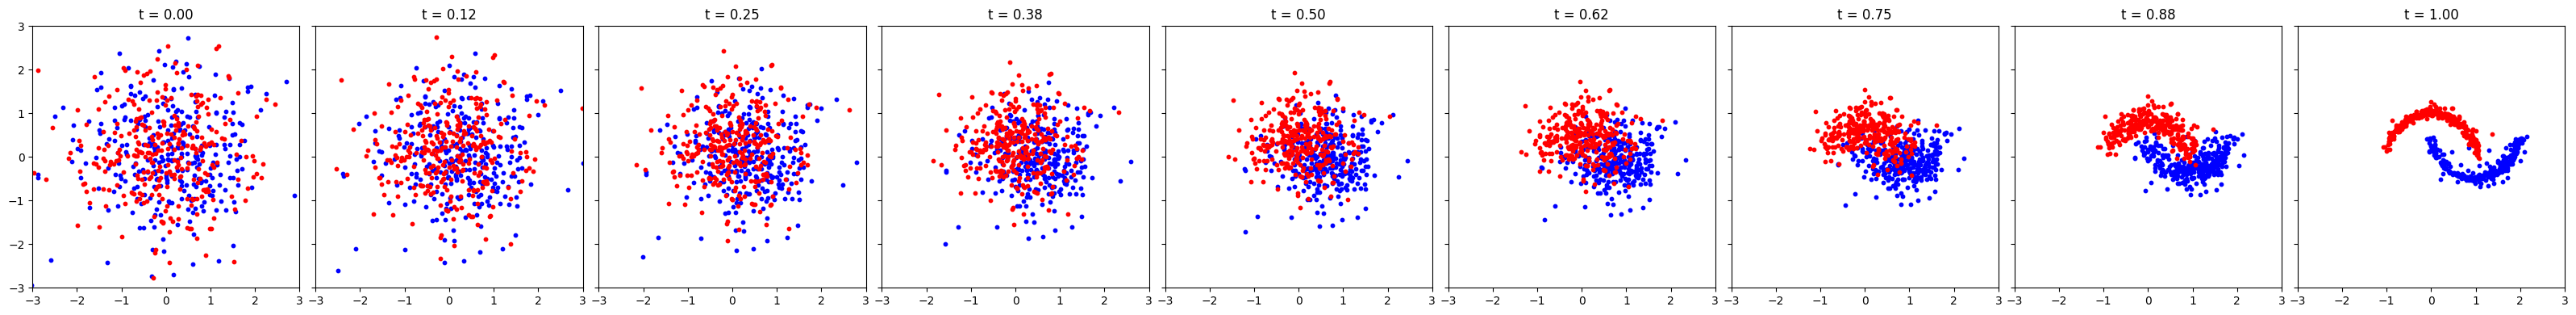

In [8]:
xa, xb = torch.randn(300, 2), torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(4*n_steps, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(xa.detach()[:, 0], xa.detach()[:, 1], s=10, c='b')
axes[0].scatter(xb.detach()[:, 0], xb.detach()[:, 1], s=10, c='r')
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    xa = flow.step(x_t=xa, t_start=time_steps[i], t_end=time_steps[i + 1], p=torch.ones((300,1)))
    xb = flow.step(x_t=xb, t_start=time_steps[i], t_end=time_steps[i + 1], p=-torch.ones((300,1)))
    axes[i + 1].scatter(xa.detach()[:, 0], xa.detach()[:, 1], s=10, c='b')
    axes[i + 1].scatter(xb.detach()[:, 0], xb.detach()[:, 1], s=10, c='r')
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()

## Sampling with classifier-free guidance (Samples adhere to class better)

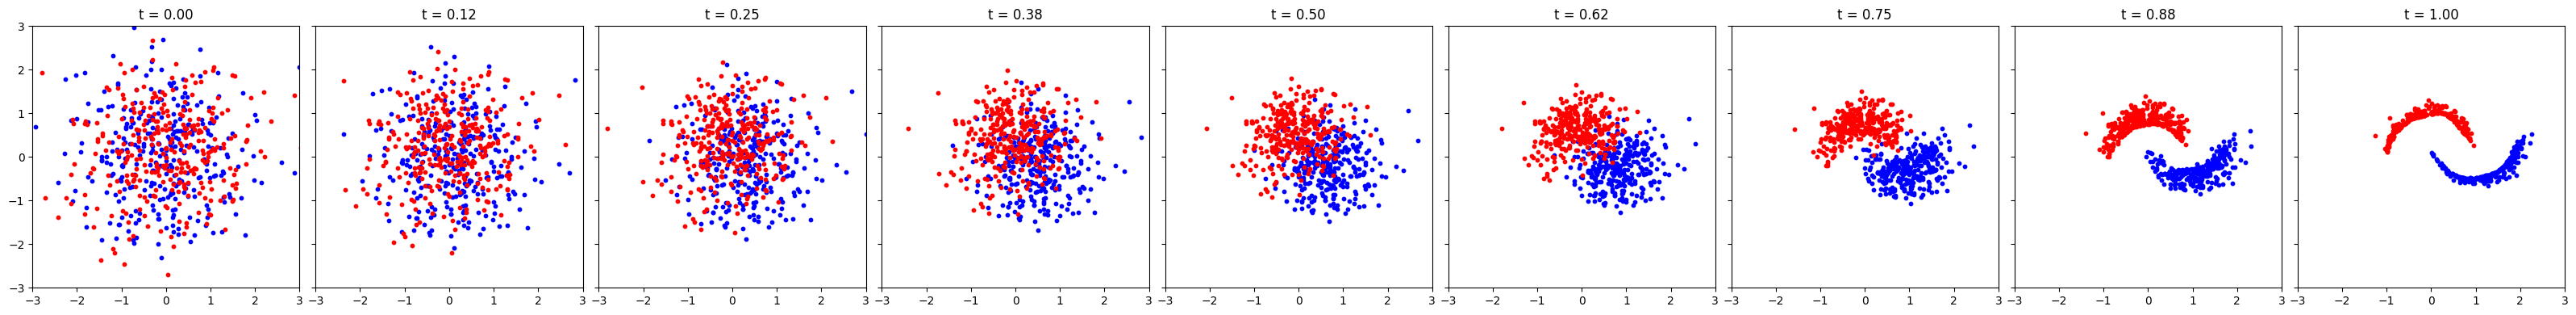

In [9]:
flow.set_guidance_scale(1.75)
xa, xb = torch.randn(300, 2), torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(4*n_steps, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(xa.detach()[:, 0], xa.detach()[:, 1], s=10, c='b')
axes[0].scatter(xb.detach()[:, 0], xb.detach()[:, 1], s=10, c='r')
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    xa = flow.step(x_t=xa, t_start=time_steps[i], t_end=time_steps[i + 1], p=torch.ones((300,1)), CFG=True)
    xb = flow.step(x_t=xb, t_start=time_steps[i], t_end=time_steps[i + 1], p=-torch.ones((300,1)), CFG=True)
    axes[i + 1].scatter(xa.detach()[:, 0], xa.detach()[:, 1], s=10, c='b')
    axes[i + 1].scatter(xb.detach()[:, 0], xb.detach()[:, 1], s=10, c='r')
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()